<a href="https://colab.research.google.com/github/PratyushJha254/BTP/blob/main/NNs_trainedOnFerro_testedOnAntiFerro_NNIsingModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Do the following:
1.   Code NNs using pytorch, test over NNN Ising Model.
2.   Train the model using antiferro data.
3.   Train on ferro test on anti-ferro (first discuss with Sir).




In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import pickle
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
import matplotlib.cm as cm
from keras.utils import to_categorical
import keras.layers as layers
from keras import Sequential
from numba import jit

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import sys
from torch.autograd import Variable
from torch.autograd import grad as torch_grad
import seaborn as sns


#### Metropolis Algorithm

In [ ]:
import numpy as np
from numba import jit

@jit(nopython=True)
def data_generation_internal(l, J=1):
    # J = 1  # coupling strength
    L = l  # grid size

    temperatures = np.arange(1, 3.51, 0.1)  # 26
    ntherm = 100  # thermalization steps
    nsamples = 100  # number of samples for every starting configuration
    nbin = 10  # number of starting configurations

    n = len(temperatures) * nbin * nsamples  # total number of samples

    C = np.empty((n, L, L))
    T = np.empty(n)

    # checkerboard pattern
    x = np.zeros((L, L), dtype=np.int64)
    x[1::2, 0::2] = 1
    x[0::2, 1::2] = 1

    c = 0
    for t in temperatures:
        for i in range(nbin):
            # start with polarized state
            grid = np.ones((L, L)) * (-1)**(i % 2)
            # draw a number of sample configurations
            for j in range(nsamples):
                # perform a number of updates until thermalization
                for k in range(ntherm):
                    # Calculate neighbors without using np.roll()
                    neighbors = np.zeros((L, L))
                    neighbors[:-1, :] += grid[1:, :]
                    neighbors[1:, :] += grid[:-1, :]
                    neighbors[:, :-1] += grid[:, 1:]
                    neighbors[:, 1:] += grid[:, :-1]
                    # calculate the potential changes in energy
                    dE = 2 * J * (grid * neighbors)
                    # calculate the transition probabilities
                    p = np.exp(-dE / t)
                    # decide which transitions will occur
                    # (avoid updating neighbors using alternating checkerboard pattern)
                    grid *= 1 - 2 * np.multiply((np.random.rand(L, L) < p).astype(np.int8), x ^ (k % 2))

                C[c] = grid
                T[c] = t
                c += 1

    return C, T

In [ ]:
def data_generation(l, name, J):
    C, T = data_generation_internal(l, J)
    p = np.random.permutation(len(C))
    np.savez_compressed(name, X=C[p], y=T[p])

In [ ]:
# data_generation(10, 'data1.npz', 1)
# data_generation(20, 'data2.npz', 1)
# data_generation(30, 'data3.npz', 1)
# data_generation(40, 'data4.npz', 1)
data_generation(64, 'data_anti.npz', -1)

#### Loading the file

In [74]:
nu_G = 10
Ny = 64
Nx = 64
nc = 1
nz = 100
ngf = 64
ndf = 64
num_epochs = 50
lr = 0.001
beta1 = 0.5
ngpu = 1
N = Ny * Nx
device = torch.device('cuda:0' if (torch.cuda.is_available() and ngpu > 0) else 'cpu')

In [7]:
def file_loader(file_name):
    data = np.load(file_name)
    X = data['X']
    y = data['y']
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.15)
    Tc = 2.27 # For a square lattice following Ising Model
    y_train = Y_train > Tc
    y_test = Y_test > Tc
    y_train = to_categorical(y_train.astype(int))
    y_test = to_categorical(y_test.astype(int))
    return X_train, X_test, y_train, y_test, Y_train, Y_test

In [8]:
# data -

# X_train1, X_test1, y_train1, y_test1, Y_train1, Y_test1 = file_loader('data1.npz')

# X_train2, X_test2, y_train2, y_test2, Y_train2, Y_test2 = file_loader('data2.npz')

# X_train3, X_test3, y_train3, y_test3, Y_train3, Y_test3 = file_loader('data3.npz')

# X_train4, X_test4, y_train4, y_test4, Y_train4, Y_test4 = file_loader('data4.npz')

X_train, X_test, y_train, y_test, Y_train, Y_test = file_loader('data.npz')

In [9]:
X_train_anti, X_test_anti, y_train_anti, y_test_anti, Y_train_anti, Y_test_anti = file_loader('data_anti.npz')

#### Dataset and DataLoader

In [70]:
class IsingDataset(Dataset):
    def __init__(self, x, y):
        self.n_samples = x.shape[0]
        self.x = torch.tensor(torch.from_numpy(x))
        self.y = torch.tensor(torch.from_numpy(y))

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.n_samples

In [71]:
training_dataset = IsingDataset(X_train, y_train)
testing_dataset = IsingDataset(X_test, y_test)
batch_size = 128
train_dataloader = DataLoader(dataset = training_dataset, batch_size = batch_size, shuffle = False)
test_dataloader = DataLoader(dataset = testing_dataset, batch_size = batch_size, shuffle = False)

<ipython-input-70-de2182b412d1>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(torch.from_numpy(x))
<ipython-input-70-de2182b412d1>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(torch.from_numpy(y))


In [72]:
training_dataset_anti = IsingDataset(X_train_anti, y_train_anti)
testing_dataset_anti = IsingDataset(X_test_anti, y_test_anti)
batch_size = 128
train_dataloader_anti = DataLoader(dataset = training_dataset_anti, batch_size = batch_size, shuffle = False)
test_dataloader_anti = DataLoader(dataset = testing_dataset_anti, batch_size = batch_size, shuffle = False)

<ipython-input-70-de2182b412d1>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(torch.from_numpy(x))
<ipython-input-70-de2182b412d1>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(torch.from_numpy(y))


#### Accuracy, train and test functions

In [2]:
def calculate_accuracy(outputs, labels):
    # Threshold the outputs at 0.5 to get binary predictions: below 0.5 becomes 0, above becomes 1
    predicted = (outputs > 0.5).float()

    # The labels need to have the same dimensions as the predictions for comparison
    # Assuming labels are already in the correct shape (batch_size, 1) or (batch_size,)
    # If not, you might need to adjust labels' shape, e.g., labels = labels.view(-1, 1)

    # Calculate the number of correct predictions
    correct = (predicted == labels).float().sum().item()/2

    # Calculate the total number of labels (which is also the batch size)
    total = labels.size(0)

    # Calculate accuracy as the percentage of correct predictions
    accuracy = correct / total
    return accuracy


In [56]:
def train(model, num_epochs, criterion, optimizer, train_dataloader):
  for epoch in range(num_epochs):
    for i, (x, label) in enumerate(train_dataloader):
      x = x.to(device).float()
      label = label.to(device).float()
      b_size = x.size(0)
      model.zero_grad()
      output = model(x)
      if(epoch==0 and i==0):
        print(output)
      error = criterion(output, label)
      error.backward()
      optimizer.step()
      acc_train = calculate_accuracy(output, label)
      if i % 20 == 0:
        print('Loss:', error.item(),',Train accuracy:', acc_train)

In [4]:
def test(model, criterion, test_dataloader):
    for i, (x, label) in enumerate(test_dataloader):
      x = x.to(device).float()
      label = label.to(device).float()
      output = model(x)
      error = criterion(output, label)
      acc_train = calculate_accuracy(output, label)
      if i % 20 == 0:
        print('Loss:', error.item(),',Test accuracy:', acc_train)

In [5]:
def get_predictions(test_loader, model):
    # Assuming `test_loader` is your DataLoader for the test dataset
    # Iterate over the test data and make predictions
    all_predictions = []
    with torch.no_grad():  # Disable gradient tracking during inference
        for inputs in test_loader:
            inputs = inputs.to(device)  # Move inputs to the device (e.g., GPU)
            _, predicted = torch.max(outputs, 1)  # Get the predicted class indices
            all_predictions.extend(outputs.cpu().numpy())  # Convert predictions to CPU and store them

    # Now `all_predictions` contains the predicted class indices for all test samples
    # You can further process or save these predictions as needed


#### Fully Connected Neural Network

In [109]:
class neural_network(nn.Module):
  def __init__(self):
    super(neural_network, self).__init__()
    self.main = nn.Sequential(
        nn.Flatten(start_dim=1,end_dim=-1),
        nn.Linear(Nx*Ny, 100),
        nn.Sigmoid(),
        nn.Linear(100, 2),
        nn.Sigmoid()
    )
  def forward(self, input):
      return self.main(input)

In [110]:
device

device(type='cuda', index=0)

In [111]:
FCNN = neural_network().to(device)
criterion_FCNN = nn.BCELoss()
optimizer_FCNN = optim.Adam(FCNN.parameters(), lr=lr, betas=(0.9, 0.999))

In [112]:
num_epochs = 50
train(FCNN, num_epochs, criterion_FCNN, optimizer_FCNN, train_dataloader)

tensor([[0.3712, 0.4709],
        [0.3539, 0.4499],
        [0.3542, 0.4511],
        [0.3708, 0.4715],
        [0.3688, 0.4860],
        [0.3831, 0.4698],
        [0.3410, 0.4622],
        [0.3744, 0.4673],
        [0.3580, 0.4440],
        [0.3502, 0.5152],
        [0.3472, 0.4766],
        [0.3710, 0.4709],
        [0.3654, 0.4616],
        [0.3701, 0.4811],
        [0.3486, 0.4710],
        [0.3403, 0.4381],
        [0.3976, 0.4630],
        [0.3729, 0.4687],
        [0.3935, 0.4552],
        [0.3730, 0.4715],
        [0.3660, 0.4674],
        [0.3639, 0.4560],
        [0.3344, 0.4789],
        [0.3725, 0.4534],
        [0.3547, 0.4532],
        [0.3544, 0.4470],
        [0.3577, 0.4630],
        [0.3529, 0.4501],
        [0.3673, 0.4612],
        [0.3722, 0.4720],
        [0.3727, 0.4701],
        [0.3297, 0.4403],
        [0.3658, 0.4639],
        [0.3700, 0.4679],
        [0.3701, 0.4690],
        [0.3564, 0.4558],
        [0.3837, 0.4497],
        [0.3734, 0.4718],
        [0.3

In [113]:
test(FCNN, criterion_FCNN, test_dataloader)

Loss: 0.10503491759300232 ,Test accuracy: 0.9609375
Loss: 0.3403957784175873 ,Test accuracy: 0.9296875


Saving the trained weights

In [ ]:
torch.save(FCNN.state_dict(), 'NeuralNetwork_weights_anti64.pth')

Loading the trained weights

In [ ]:
FCNN.load_state_dict(torch.load('model_weights.pth'))

#### CNN

In [117]:
# model = Sequential([
#           layers.Reshape(target_shape=(40,40,1), input_shape=(40,40)),
#           layers.Conv2D(128, (3,3), padding='valid', activation='relu'),
#           layers.Flatten(),
#           layers.Dense(128, activation='relu'),
#           layers.Dropout(.5),
#           layers.Dense(2, activation='softmax')
#         ])
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self, Nx, Ny):
        super(ConvNet, self).__init__()
        # Equivalent to Reshape in Keras, but in PyTorch, reshaping is typically done in the forward method.
        # Conv2D layer with 128 filters, kernel size of 3x3, padding='valid' implies no padding in PyTorch
        self.conv1 = nn.Conv2d(1, 128, kernel_size=3, padding=0)
        # Determine the output size of the first convolutional layer
        out_conv1 = self._calculate_output_size((Nx, Ny), kernel_size=3, padding=0)
        # Dense layer with 128 units
        self.fc1 = nn.Linear(128 * out_conv1[0] * out_conv1[1], 128)
        # Dropout layer with p=0.5
        self.dropout = nn.Dropout(p=0.5)
        # Output Dense layer with 2 units for softmax output
        self.fc2 = nn.Linear(128, 2)
        self.flatten = nn.Flatten()

    def forward(self, x):
        # Reshape input to have one channel
        x = x.view(-1, 1, x.size(1), x.size(2))
        # Applying Convolutional Layer
        x = F.relu(self.conv1(x))
        # Flattening the output of the conv layer
        x = self.flatten(x)     # ------------------
        # Dense layer with ReLU activation
        x = F.relu(self.fc1(x))
        # Dropout layer
        x = self.dropout(x)
        # Output layer with softmax activation
        x = self.fc2(x)
        return F.softmax(x, dim=1)

    def _calculate_output_size(self, input_size, kernel_size, padding):
        # Calculate output size after convolutional layer
        out_size = [(input_size[0] - kernel_size + 2 * padding) + 1,
                    (input_size[1] - kernel_size + 2 * padding) + 1]
        return out_size


In [118]:
# model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['binary_accuracy'])
CNN = ConvNet(Nx, Ny).to(device)
criterion_CNN = nn.BCELoss()
optimizer_CNN = optim.Adam(CNN.parameters(), lr=lr, betas=(0.9, 0.999))

In [119]:
train(CNN, 10, criterion_CNN, optimizer_CNN, train_dataloader)

tensor([[0.4780, 0.5220],
        [0.5543, 0.4457],
        [0.5361, 0.4639],
        [0.5466, 0.4534],
        [0.4472, 0.5528],
        [0.5058, 0.4942],
        [0.5929, 0.4071],
        [0.5377, 0.4623],
        [0.5004, 0.4996],
        [0.5794, 0.4206],
        [0.5884, 0.4116],
        [0.4986, 0.5014],
        [0.5812, 0.4188],
        [0.5103, 0.4897],
        [0.5502, 0.4498],
        [0.5014, 0.4986],
        [0.5728, 0.4272],
        [0.4188, 0.5812],
        [0.5493, 0.4507],
        [0.5012, 0.4988],
        [0.5858, 0.4142],
        [0.5213, 0.4787],
        [0.5395, 0.4605],
        [0.4668, 0.5332],
        [0.5648, 0.4352],
        [0.5160, 0.4840],
        [0.6187, 0.3813],
        [0.5667, 0.4333],
        [0.4915, 0.5085],
        [0.5721, 0.4279],
        [0.6411, 0.3589],
        [0.5707, 0.4293],
        [0.5912, 0.4088],
        [0.5270, 0.4730],
        [0.6177, 0.3823],
        [0.4824, 0.5176],
        [0.5185, 0.4815],
        [0.5136, 0.4864],
        [0.4

In [ ]:
test(CNN, criterion_CNN, test_dataloader)

In [ ]:
outputs = get_predictions(test_dataloader, CNN)
plt.scatter(outputs, Y_test)

#### Previous code

-----------------------------------------------------
Write a code to evaluate the model, you may do so by adding evaluation related steps in the training loop as well.<br>
Plot the graphs as required.<br>
Plot the graph by testing the model on NNN case as well.<br>
Code a CNN model and perform all the actions as performed on an neural network.

In [ ]:
print('MODEL1')
model1 = keras.Sequential()
model1 = neural(model1, X_train1, X_test1, y_train1, y_test1)
print('MODEL3')
model3 = keras.Sequential()
model3 = neural(model3, X_train3, X_test3, y_train3, y_test3)
print('MODEL4')
model4 = keras.Sequential()
model4 = neural(model4, X_train4, X_test4, y_train4, y_test4)


MODEL1
122/122 [==============================] - 4s 2ms/step - loss: 0.1936 - accuracy: 0.9279
MODEL3
122/122 [==============================] - 4s 2ms/step - loss: 0.1081 - accuracy: 0.9708
MODEL4
122/122 [==============================] - 4s 2ms/step - loss: 0.1187 - accuracy: 0.9697


Text(0, 0.5, 'Accuracy')

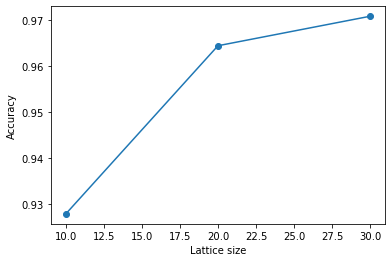

In [ ]:
plt.plot([10,20,30], [0.9279,0.9644, 0.9708])
plt.scatter([10,20,30], [0.9279,0.9644, 0.9708])
plt.xlabel('Lattice size')
plt.ylabel('Accuracy')

In [ ]:
def preds(model, X_test, size):
    l = []

#     print('PREDICTIONS:')
    for i in range(1,size):
#         print('i=',i)
        l.append(model.predict(X_test[(i-1):(i)], verbose = 0))
    l = np.array(l)

    return l

In [ ]:
def sortIt(l, y):
    size = l.shape[0]
    a = np.zeros(size)
    b = np.zeros(size)
    l1 = np.zeros(size)
    l2 = np.zeros(size)
    for x in range(size):
      a[x]=l[x][0][0]
      b[x]=l[x][0][1]
      l1[x]=y[x]

    c = np.array([l1, a])
    sorted_c = c.T[l1.argsort()]

    d = np.array([l1, b])
    sorted_d = d.T[l1.argsort()]

    return sorted_c, sorted_d

In [ ]:
def plotIt(sorted, y_test, yes=True):

    t = np.arange(1, 3.51, 0.1)
    vals = np.zeros(t.shape[0])
    x_axisc = sorted[:,0]
    y_axis = sorted[:,1]
    k2=0

    for i in t:
        val=0
        count=0
        flag=0
        k=0
        for j in x_axis:
            if(i==j):
                val=val+y_axis[k]
                count=count+1
                flag=1
            k=k+1
        if(flag==1):
            vals[k2] = val/count
        if(flag==0 and k2!=0):
            vals[k2] = vals[k2-1]
        k2+=1

    plt.plot(t, vals)

#     if(yes):
#         first_line = LineString(np.column_stack((t, vals)))
#         return first_line
#     else:
#         second_line = LineString(np.column_stack((t, vals)))
#         return second_line

In [ ]:
l1 = preds(model1, X_test1, size)

In [ ]:
# l = preds(model, X_test2, size)


In [ ]:
l3 = preds(model3, X_test3, size)


In [ ]:
# l4 = preds(model3, X_test4, size)

In [ ]:
def plot_all(model, l, X_test2, y_test2, Y_test2, size = 100):

#     l = preds(model, X_test2, size)
    sorted_c, sorted_d = sortIt(l, Y_test2)
    plotIt(sorted_c, y_test2)
    plotIt(sorted_d, y_test2)
    return sorted_c[:,0], sorted_c[:,1], sorted_d[:,0], sorted_d[:,1], val1, val2

Text(0, 0.5, 'Output Layer')

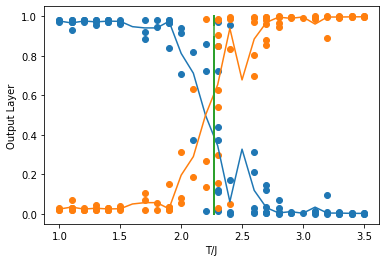

In [ ]:
from shapely.geometry import LineString

scx1, scy1, sdx1, sdy1 = plot_all(model1, l1, X_test1, y_test1, Y_test1)
plt.scatter(scx1, scy1)
plt.scatter(sdx1, sdy1)
plt.plot(np.linspace(2.27,2.27,scy3.shape[0]),scy3)
# scx2, scy2, sdx2, sdy2 = plot_all(model3, l, X_test2, y_test2, Y_test2)
# scx3, scy3, sdx3, sdy3 = plot_all(model3, l3, X_test3, y_test3, Y_test3)
plt.xlabel('T/J')
plt.ylabel('Output Layer')



Text(0, 0.5, 'Output Layer')

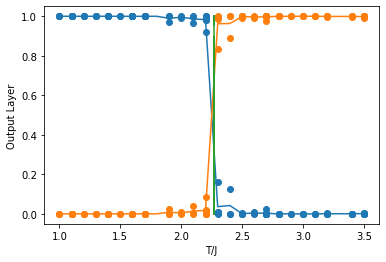

In [ ]:
scx2, scy2, sdx2, sdy2 = plot_all(model3, l, X_test2, y_test2, Y_test2)
plt.scatter(scx2, scy2)
plt.scatter(sdx2, sdy2)
plt.plot(np.linspace(2.27,2.27,scy3.shape[0]),scy3)
plt.xlabel('T/J')
plt.ylabel('Output Layer')

Text(0, 0.5, 'Output Layer')

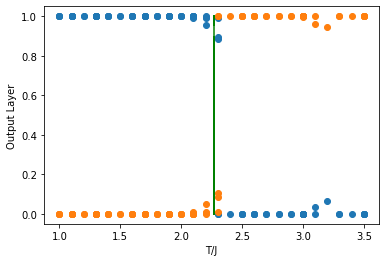

In [ ]:
plt.scatter(scx3, scy3)
plt.scatter(sdx3, sdy3)
# plt.scatter(sdx3, sdy3)
plt.plot(np.linspace(2.27,2.27,scy3.shape[0]),scy3, color='g')
plt.xlabel('T/J')
plt.ylabel('Output Layer')

In [ ]:
def plotIt2(sorted, y_test, latt):

    t = np.arange(1, 3.51, 0.1)
    vals = np.zeros(t.shape[0])
    x_axisc = sorted[:,0]
    y_axis = sorted[:,1]
    k2=0

    for i in t:
        val=0
        count=0
        flag=0
        k=0
        for j in x_axis:
            if(i==j):
                val=val+y_axis[k]
                count=count+1
                flag=1
            k=k+1
        if(flag==1):
            vals[k2] = val/count
        if(flag==0 and k2!=0):
            vals[k2] = vals[k2-1]
        k2+=1

    plt.plot(t, (vals-2.27)*(latt))

In [ ]:
# plt.scatter(scx1, (scy1-2.27)*(10))
# plt.scatter(sdx1, (sdy1-2.27)*(10))
# sorted_c, sorted_d = sortIt(l, Y_test1)
# plotIt2(sorted_c, y_test1, 10)
# plotIt2(sorted_d, y_test1, 10)
# plt.xlabel('$tL^{1/v}$')
# plt.ylabel('Output Layer')

##### CNN

In [ ]:
model = Sequential([
          layers.Reshape(target_shape=(40,40,1), input_shape=(40,40)),
          layers.Conv2D(128, (3,3), padding='valid', activation='relu'),
          layers.Flatten(),
          layers.Dense(128, activation='relu'),
          layers.Dropout(.5),
          layers.Dense(2, activation='softmax')
        ])


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

hist = model.fit(X_train4[:1000], y_train4[:1000], epochs=10, batch_size=32, validation_data = (X_test4[:100], y_test4[:100]))


Epoch 1/10
32/32 [==============================] - 16s 369ms/step - loss: 0.5765 - binary_accuracy: 0.9080 - val_loss: 0.0919 - val_binary_accuracy: 0.9700
Epoch 2/10
32/32 [==============================] - 11s 341ms/step - loss: 0.0624 - binary_accuracy: 0.9820 - val_loss: 0.0451 - val_binary_accuracy: 0.9800
Epoch 3/10
32/32 [==============================] - 11s 345ms/step - loss: 0.0301 - binary_accuracy: 0.9930 - val_loss: 0.0032 - val_binary_accuracy: 1.0000
Epoch 4/10
32/32 [==============================] - 11s 338ms/step - loss: 0.0195 - binary_accuracy: 0.9950 - val_loss: 0.0496 - val_binary_accuracy: 0.9900
Epoch 5/10
32/32 [==============================] - 11s 342ms/step - loss: 0.0116 - binary_accuracy: 0.9960 - val_loss: 0.0022 - val_binary_accuracy: 1.0000
Epoch 6/10
32/32 [==============================] - 9s 289ms/step - loss: 0.0056 - binary_accuracy: 0.9980 - val_loss: 0.0131 - val_binary_accuracy: 0.9900
Epoch 7/10
32/32 [==============================] - 9s 288m